Install packages

In [63]:
!pip install pytdc catboost rdkit scikit-learn pandas numpy

Import the Dataset 

In [64]:
from tdc.single_pred import Tox
from sklearn import svm

data = Tox(name = 'hERG_Karim')
df = data.get_data()
df #view dataframe to explore

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,0,Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F,1
1,1,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,0
2,2,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,0
3,3,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,0
4,4,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,0
...,...,...,...
13440,13440,Cc1csc(NC(=O)c2sc3nc4c(c(C(F)(F)F)c3c2N)CCC4)n1,0
13441,13441,Cc1cccc(-c2n[nH]cc2-c2ccc3ncccc3n2)n1,0
13442,13442,Cc1ccccc1-n1c(Cn2cnc3c(N)ncnc32)nc2cccc(C)c2c1=O,0
13443,13443,Cc1ccccc1-n1c(Cn2ncc3c(N)ncnc32)nc2cccc(C)c2c1=O,0


Import Necessary Packages and Functions

In [65]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops



Feature Engineering

In [66]:
#data conversion
split = data.get_split()
smiles_train = split['train']['Drug']
Y_train = split['train']['Y']
smiles_valid = split['valid']['Drug']
Y_valid = split['valid']['Y']

# Compute MACCS Keys
def compute_maccs_fingerprint(smiles): 
    mol = Chem.MolFromSmiles(smiles)
    maccs = MACCSkeys.GenMACCSKeys(mol)
    return np.array(maccs)

# Compute additional molecular descriptors
def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    descriptors = []
    # Molecular weight
    descriptors.append(Descriptors.MolWt(mol))
    # LogP (octanol-water partition coefficient)
    descriptors.append(Descriptors.MolLogP(mol))
    # Topological Polar Surface Area (TPSA)
    descriptors.append(Descriptors.TPSA(mol))
    # Number of rotatable bonds
    descriptors.append(Descriptors.NumRotatableBonds(mol))
    # Aromaticity (True/False)
    descriptors.append(Descriptors.NumAromaticRings(mol))
    # Hydrogen Bond Donors and Acceptors
    descriptors.append(Descriptors.NumHDonors(mol))
    descriptors.append(Descriptors.NumHAcceptors(mol))

    return np.array(descriptors)

#Compute Morgan fingerprints
def compute_morgan_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return np.array(fingerprint)

# Compute all
def compute_combined_fingerprints(smiles):
    # Compute Morgan Fingerprint
    morgan_fingerprint = compute_morgan_fingerprint(smiles)

    # Compute MACCS Fingerprint
    maccs_fingerprint = compute_maccs_fingerprint(smiles)

    # Compute molecular descriptors
    molecular_descriptors = compute_molecular_descriptors(smiles)

    # Combine all features into a single vector
    combined_features = np.concatenate([morgan_fingerprint, maccs_fingerprint, molecular_descriptors])

    return combined_features

train_features = smiles_train.apply(compute_combined_fingerprints)
X_train_combined = np.stack(train_features.values)

# Compute features for validation data
valid_features = smiles_valid.apply(compute_combined_fingerprints)
X_valid_combined = np.stack(valid_features.values)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_valid_scaled = scaler.transform(X_valid_combined)
train_features = smiles_train.apply(compute_combined_fingerprints)
X_train_combined = np.stack(train_features.values)

valid_features = smiles_valid.apply(compute_combined_fingerprints)
X_valid_combined = np.stack(valid_features.values)
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of Y_train:", Y_train.shape)


Shape of X_train_scaled: (9412, 1198)
Shape of Y_train: (9412,)


Train and Evaluate Models

In [67]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, Y_train)

# Predict and evaluate Random Forest model
y_pred_rf = rf_model.predict(X_valid_scaled)
y_prob_rf = rf_model.predict_proba(X_valid_scaled)
print("Random Forest Accuracy:", accuracy_score(Y_valid, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(Y_valid, y_pred_rf))
print("Random Forest AUC: ", roc_auc_score(Y_valid, y_prob_rf[:,1]))

Random Forest Accuracy: 0.8608630952380952
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       683
           1       0.85      0.86      0.86       661

    accuracy                           0.86      1344
   macro avg       0.86      0.86      0.86      1344
weighted avg       0.86      0.86      0.86      1344

Random Forest AUC:  0.9254512551416174


In [68]:
# Train SVM model
#Best parameters found from randomized search: {'C': 1.6599452033620266, 'gamma': 0.06808361216819946, 'kernel': 'poly'}
svm_model = SVC(kernel='poly', random_state=42, probability=True, C=1.7, gamma= 0.07)
svm_model.fit(X_train_scaled, Y_train)

# Predict and evaluate SVM model
y_pred_svm = svm_model.predict(X_valid_scaled)
y_prob_svm = svm_model.predict_proba(X_valid_scaled)
print("SVM Accuracy:", accuracy_score(Y_valid, y_pred_svm))
print("SVM Classification Report:\n", classification_report(Y_valid, y_pred_svm))
print("SVM AUC: ", roc_auc_score(Y_valid, y_prob_svm[:,1]))

SVM Accuracy: 0.8333333333333334
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       683
           1       0.81      0.86      0.84       661

    accuracy                           0.83      1344
   macro avg       0.83      0.83      0.83      1344
weighted avg       0.83      0.83      0.83      1344

SVM AUC:  0.9127868728998833


In [69]:
#Train XGBoost
#Best parameters found from randomized search: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.6}
model = XGBClassifier(
    subsample = 0.8,
    reg_lambda = 3,
    reg_alpha = 1,
    max_depth=9,
    learning_rate=0.3,
    n_estimators=200,
    gamma = 0,
    colsample_bytree=0.6,
    random_state=42
)

model.fit(X_train_scaled, Y_train)
y_pred_xg = model.predict(X_valid_scaled)
y_prob_xg = model.predict_proba(X_valid_scaled)
print("XGBoost Validation accuracy:", accuracy_score(Y_valid, y_pred_xg))
print("XGBoost Classification report:\n", classification_report(Y_valid, y_pred_xg))
print("XGBoost AUC: ", roc_auc_score(Y_valid, y_prob_xg[:,1]))

XGBoost Validation accuracy: 0.8660714285714286
XGBoost Classification report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       683
           1       0.86      0.87      0.86       661

    accuracy                           0.87      1344
   macro avg       0.87      0.87      0.87      1344
weighted avg       0.87      0.87      0.87      1344

XGBoost AUC:  0.9245608167225221


In [79]:

# Initialize CatBoost model with parameters (manually specified hyperparameters)
model = CatBoostClassifier(
    iterations=200,            # Number of boosting iterations
    learning_rate=0.3,         # Learning rate
    depth=9,                   # Depth of the tree
    l2_leaf_reg=3,             # L2 regularization term
    random_seed=42,            # Random state
    logging_level='Silent',    # Suppress training logs
    eval_metric='AUC'          # Evaluation metric
)

# Train the CatBoost model
model.fit(X_train_scaled, Y_train, eval_set=(X_valid_scaled, Y_valid))

# Predict on validation set
y_pred_cat = model.predict(X_valid_scaled)
y_prob_cat = model.predict_proba(X_valid_scaled)

# Evaluate the model
print("CatBoost Validation Accuracy:", accuracy_score(Y_valid, y_pred_cat))
print("CatBoost Classification Report:\n", classification_report(Y_valid, y_pred_cat))
print("CatBoost AUC:", roc_auc_score(Y_valid, y_prob_cat[:, 1]))





CatBoost Validation Accuracy: 0.8571428571428571
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       683
           1       0.85      0.87      0.86       661

    accuracy                           0.86      1344
   macro avg       0.86      0.86      0.86      1344
weighted avg       0.86      0.86      0.86      1344

CatBoost AUC: 0.9195637294750623


In [71]:
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Length of Y_train:", len(Y_train))


Shape of X_train_scaled: (9412, 1198)
Length of Y_train: 9412


In [72]:
# Randomnized Search CV:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Initialize CatBoost model
catboost_model = CatBoostClassifier(
    random_seed=42,
    logging_level='Silent',
    eval_metric='AUC'
)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings to sample
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_scaled, Y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Evaluate the best model on the validation set
y_pred_best = best_model.predict(X_valid_scaled)
y_prob_best = best_model.predict_proba(X_valid_scaled)
print("Best Model Validation Accuracy:", accuracy_score(Y_valid, y_pred_best))
print("Best Model AUC:", roc_auc_score(Y_valid, y_prob_best[:, 1]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 10}
Best Model Validation Accuracy: 0.8563988095238095
Best Model AUC: 0.9250879917069615


In [73]:
smiles_test = split['test']['Drug']
Y_test = split['test']['Y']

# Compute features for validation data
valid_features = smiles_test.apply(compute_combined_fingerprints)
X_test_combined = np.stack(valid_features.values)

# Scale the features
X_test_scaled = scaler.transform(X_test_combined)

In [74]:
#predict test for xgboost 
y_test_xg = model.predict(X_test_scaled)
yprob_test_xg = model.predict_proba(X_test_scaled)

#predict test for random forest
y_test_rf = rf_model.predict(X_test_scaled)
yprob_test_rf = rf_model.predict_proba(X_test_scaled)

print("XGBoost Validation accuracy:", accuracy_score(Y_test, y_test_xg))
print("XGBoost Classification report:\n", classification_report(Y_test, y_test_xg))
print("XGBoost AUC: ", roc_auc_score(Y_test, yprob_test_rf[:,1]))


print("\nRandom Forest Validation accuracy:", accuracy_score(Y_test, y_test_rf))
print("Random Forest Classification report:\n", classification_report(Y_test, y_test_rf))
print("Random Forest AUC: ", roc_auc_score(Y_test, yprob_test_rf[:,1]))

XGBoost Validation accuracy: 0.8493863889921904
XGBoost Classification report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1346
           1       0.84      0.86      0.85      1343

    accuracy                           0.85      2689
   macro avg       0.85      0.85      0.85      2689
weighted avg       0.85      0.85      0.85      2689

XGBoost AUC:  0.9255686023727677

Random Forest Validation accuracy: 0.8549646708813685
Random Forest Classification report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1346
           1       0.85      0.85      0.85      1343

    accuracy                           0.85      2689
   macro avg       0.85      0.85      0.85      2689
weighted avg       0.85      0.85      0.85      2689

Random Forest AUC:  0.9255686023727677


In [83]:
#predict test for CatBoost 
y_test_cat = model.predict(X_test_scaled)
yprob_test_cat = model.predict_proba(X_test_scaled)
print("CatBoost Validation accuracy:", accuracy_score(Y_test, y_test_cat))
print("CatBoost Classification report:\n", classification_report(Y_test, y_test_cat))
print("CatBoost AUC: ", roc_auc_score(Y_test, yprob_test_cat[:,1]))


CatBoost Validation accuracy: 0.8341390851617702
CatBoost Classification report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1346
           1       0.83      0.84      0.84      1343

    accuracy                           0.83      2689
   macro avg       0.83      0.83      0.83      2689
weighted avg       0.83      0.83      0.83      2689

CatBoost AUC:  0.9146747927451682


In [76]:
importances = rf_model.feature_importances_

# Rank features by importance
sorted_indices = importances.argsort()[::-1]

print("Feature rankings:")
for i in sorted_indices:
    print(f"Feature {i}: {importances[i]:.4f}")

Feature rankings:
Feature 1192: 0.0413
Feature 1193: 0.0276
Feature 1191: 0.0181
Feature 1194: 0.0107
Feature 1197: 0.0097
Feature 1196: 0.0094
Feature 807: 0.0074
Feature 1170: 0.0067
Feature 1160: 0.0061
Feature 1195: 0.0061
Feature 893: 0.0056
Feature 1178: 0.0052
Feature 1155: 0.0050
Feature 1164: 0.0049
Feature 1163: 0.0042
Feature 767: 0.0038
Feature 219: 0.0038
Feature 650: 0.0036
Feature 1183: 0.0036
Feature 887: 0.0035
Feature 1110: 0.0033
Feature 1152: 0.0031
Feature 511: 0.0031
Feature 1119: 0.0029
Feature 1179: 0.0028
Feature 1175: 0.0027
Feature 1149: 0.0027
Feature 1142: 0.0027
Feature 1171: 0.0026
Feature 1153: 0.0026
Feature 1124: 0.0026
Feature 1162: 0.0026
Feature 1147: 0.0024
Feature 389: 0.0024
Feature 1101: 0.0024
Feature 310: 0.0023
Feature 1131: 0.0023
Feature 1156: 0.0023
Feature 128: 0.0022
Feature 147: 0.0022
Feature 1157: 0.0022
Feature 484: 0.0022
Feature 80: 0.0022
Feature 216: 0.0022
Feature 1158: 0.0021
Feature 1121: 0.0021
Feature 1104: 0.0021
Feature 12

In [32]:
import pandas as pd

# Simulating an issue where Tox is not a DataFrame
class Tox:
    def __init__(self):
        self.data = pd.DataFrame({'col1': [1, 2, 3], 'col2': [4, 5, 6]})

tox_instance = Tox()

# Fix: Access the correct DataFrame attribute
Tox_df = tox_instance.data
Tox_df = Tox_df.drop('col1', axis=1)  # Example dropping a column
print(Tox_df)


   col2
0     4
1     5
2     6


In [34]:
print(df.head())
print(df.info())


   Drug_ID                                               Drug  Y
0        0                  Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F  1
1        1  COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...  0
2        2  CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...  0
3        3  N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...  0
4        4  O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13445 entries, 0 to 13444
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  13445 non-null  int64 
 1   Drug     13445 non-null  object
 2   Y        13445 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 315.2+ KB
None


In [35]:
X = df.drop(columns=["Drug_ID"])  # Replace "Target" with the actual column name for your target variable
Y = df["Drug_ID"]


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)


In [84]:
from catboost import Pool


In [85]:
# Extract Features from SMILES Strings
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np

def smiles_to_morgan(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros(nBits)

# Example data
data = pd.DataFrame({'SMILES': ['CCO', 'C1=CC=CC=C1'], 'drug_type': ['type1', 'type2'], 'label': [1, 0]})

# Convert SMILES to Morgan fingerprints
data['fingerprints'] = data['SMILES'].apply(smiles_to_morgan)
fingerprint_features = np.vstack(data['fingerprints'])

# Add numerical features from fingerprints
numerical_data = pd.DataFrame(fingerprint_features, columns=[f"fp_{i}" for i in range(fingerprint_features.shape[1])])

# Combine with other features
data = pd.concat([data.drop(columns=['SMILES', 'fingerprints']), numerical_data], axis=1)


In [86]:
# Step 2, 3: Specify Categorical Features and Train CatBoost with Mixed Data
categorical_features = ['drug_type']  # Specify categorical columns by name or index
from catboost import CatBoostClassifier, Pool

# Split features and labels
X = data.drop(columns=['label'])
y = data['label']

# Create Pool with categorical features
train_pool = Pool(data=X, label=y, cat_features=categorical_features)

# Train the model
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, logging_level='Silent')
model.fit(train_pool)

# Get feature importances
feature_importances = model.get_feature_importance(train_pool)

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")


Feature: drug_type, Importance: 32.50973216067223
Feature: fp_0, Importance: 0.0
Feature: fp_1, Importance: 0.0
Feature: fp_2, Importance: 0.0
Feature: fp_3, Importance: 0.0
Feature: fp_4, Importance: 0.0
Feature: fp_5, Importance: 0.0
Feature: fp_6, Importance: 0.0
Feature: fp_7, Importance: 0.0
Feature: fp_8, Importance: 0.0
Feature: fp_9, Importance: 0.0
Feature: fp_10, Importance: 0.0
Feature: fp_11, Importance: 0.0
Feature: fp_12, Importance: 0.0
Feature: fp_13, Importance: 0.0
Feature: fp_14, Importance: 0.0
Feature: fp_15, Importance: 0.0
Feature: fp_16, Importance: 0.0
Feature: fp_17, Importance: 0.0
Feature: fp_18, Importance: 0.0
Feature: fp_19, Importance: 0.0
Feature: fp_20, Importance: 0.0
Feature: fp_21, Importance: 0.0
Feature: fp_22, Importance: 0.0
Feature: fp_23, Importance: 0.0
Feature: fp_24, Importance: 0.0
Feature: fp_25, Importance: 0.0
Feature: fp_26, Importance: 0.0
Feature: fp_27, Importance: 0.0
Feature: fp_28, Importance: 0.0
Feature: fp_29, Importance: 0.0


In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [52]:
# Get feature importance
importance = model.get_booster().get_score(importance_type='gain')

# Print feature importance
for feature, score in importance.items():
    print(f"Feature: {feature}, Importance: {score}")


Feature: f0, Importance: 0.03879285231232643
Feature: f1, Importance: 0.10173123329877853
Feature: f2, Importance: 2.6351394653320312
Feature: f3, Importance: 0.7264124751091003


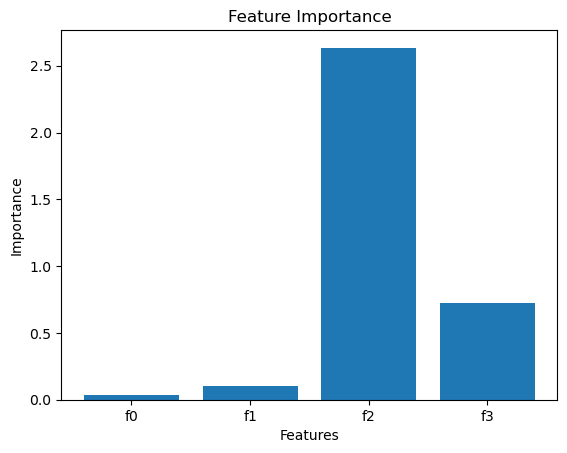

In [57]:
import matplotlib.pyplot as plt

features = ['f0', 'f1', 'f2', 'f3']
importance = [0.03879, 0.10173, 2.6351, 0.72641]

plt.bar(features, importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()


In [78]:
import sklearn  # Replace 'sklearn' with the package you are checking
print(sklearn.__version__)


1.2.2


In [88]:
pip show pytdc


Name: PyTDC
Version: 1.0.0
Summary: Therapeutics Data Commons
Home-page: https://github.com/mims-harvard/TDC
Author: TDC Team
Author-email: alejandro_velez-arce@hms.harvard.edu
License: MIT
Location: /opt/anaconda3/envs/demo/lib/python3.9/site-packages
Requires: biopython, cellxgene-census, dataclasses, fuzzywuzzy, gget, huggingface-hub, mygene, numpy, openpyxl, pandas, pydantic, rdkit, requests, scikit-learn, seaborn, tiledbsoma, tqdm, yapf
Required-by: 
Note: you may need to restart the kernel to use updated packages.
